In [56]:
import pandas as pd
import numpy as np
import pickle

In [57]:
READ_ONLY = True

In [58]:
def format_df(df):
    df.index = df.apply(lambda row: '{}:{}'.format(row['chrom'], row['pos']), axis='columns')
    df['cov'] = df['meth_+'] + df['meth_-']
    df['meth'] = df['meth_+'] / df['cov']
    df = df.loc[:, ('cov', 'meth')]
    return df

def read_cov(file):
    df = pd.read_csv(file, delimiter='\t', header=None,
                     names=('chrom', 'from_0', 'to_1', 'meth_%', 'meth_+', 'meth_-'),
                     usecols=('chrom', 'to_1', 'meth_+', 'meth_-'))
    df['pos'] = df['to_1']
    return format_df(df)

def read_bedgraph(file):
    df = pd.read_csv(file, delimiter='\t', header=None, skiprows=1,
                     names=('chrom', 'from_1', 'to_1', 'meth_%', 'meth_+', 'meth_-'),
                     usecols=('chrom', 'to_1', 'meth_+', 'meth_-'))
    df['pos'] = df['to_1']
    return format_df(df)

def read_cgmap(file):
    df = pd.read_csv(file, delimiter='\t', header=None, skiprows=1,
                     names=('chrom', 'base', 'pos_1', 'ctx', 'dinuc_ctx', 'meth_%', 'meth_+', 'meth_-'),
                     usecols=('chrom', 'pos_1', 'meth_+', 'meth_-'))
    df['pos'] = df['pos_1']
    return format_df(df)

In [65]:
from glob import glob
import re

def rename_axes(df):
    df.index = df.index.set_names('person')
    df.columns = df.columns.set_names('site')
    return df

def sort_sites(sites):
    return sites.map(lambda site: float('.'.join(site.replace('X', '23')
                                                 .replace('Y', '24')
                                                 .replace('GL', '25')
                                                 .replace('.1:', '')
                                                 .replace('MT', '26').split(':'))))

def get_chrom(sites):
    return [x.split(':')[0] for x in sites]

def sort_df(df):
    df = df.sort_index(axis='columns', key=sort_sites)
    df = df.sort_index(axis='index')
    return df

def rename_sites(df, method, save=False):
    file = './{}_site_map.pkl'.format(method)
    
    if save:
        site_map = pd.Series(df.columns).to_dict()
        site_map = {v: k for k, v in site_map.items()} # old_site -> new_site
        with open(file, 'wb') as f:
            pickle.dump(site_map, f)
    else:
        with open(file, 'rb') as f:
            site_map = pickle.load(f)
        
    df.columns = df.columns.map(site_map)
    return df

def read_files(dir_name, suffix_regex, reader):
    covs, meths = {}, {}

    for file in glob('{}/*'.format(dir_name)):
        matches = re.findall('.+/.*((EDU|IG|V)[^_]+).*{}$'.format(suffix_regex), file)

        if len(matches) != 1:
            continue

        person = matches[0][0]
        #print(person)
        df = reader(file)
        cov, meth = df['cov'], df['meth']
        cov.name, meth.name = person, person

        # A person may have multiple methylation data from different experiments
        if person in covs:
            old_cov, old_meth = covs[person], meths[person]
            df = pd.DataFrame([old_cov, cov]) # This adds missing sites to one another
            sites_to_update = df.iloc[1, :] > df.iloc[0, :] # Sites where new coverage is more than old

            # Update cov/meth for sites where new data has larger coverage
            cov = cov.reindex_like(sites_to_update).where(sites_to_update, old_cov)
            meth = meth.reindex_like(sites_to_update).where(sites_to_update, old_meth)
    
        covs[person] = cov
        meths[person] = meth

    meths = pd.DataFrame.from_dict(meths, orient='index')
    covs = pd.DataFrame.from_dict(covs, orient='index').fillna(0).astype(np.int32)
    
    return rename_axes(covs), rename_axes(meths)

def filter_data(cov, meth, min_cov=300, max_site_na=0.5, max_person_na=0.5):
    cov_true = cov[cov > 0].dropna(how='all', axis='columns')
    shape = cov_true.shape
    cov = cov[cov >= min_cov]
    meth = meth.mask(cov.isna())
    cov = cov.loc[:, cov.isna().sum(axis='index') < cov.shape[0] * max_site_na] # Remove sites with too many missing values
    cov = cov.loc[cov.isna().sum(axis='columns') < cov.shape[1] * max_person_na, :] # Remove persons with too many missing sites
    print('Retained {}/{} sites and {}/{} persons at min_cov={} max_site_na={:.0%} max_person_na={:.0%}'
          .format(cov.shape[1], shape[1], cov.shape[0], shape[0], min_cov, max_site_na, max_person_na))
    meth = meth.loc[cov.index, cov.columns]
    return cov.fillna(0).astype(np.int32), meth

In [67]:
# (name, filename suffix regex, reader function)
file_configs = [('bismark', '\.bismark\.cov', read_cov)]
                #('bwameth', '_C(HH|HG|pG)\.bedGraph', read_bedgraph),
                #('bsseeker', '\.bam\.CGmap', read_cgmap)]

# (name, individual's name prefix regex)
groups = [('ALL', ''), ('IGA+IGN', 'IG(A|N)'), ('IGA+IGN+EDU', 'IG(A|N)|EDU'), ('V', 'V')]

if not READ_ONLY:
    for method, suffix_regex, reader in file_configs:
        print('Method {}'.format(method))
        cov, meth = read_files('../meth', suffix_regex, reader)
        cov, meth = rename_sites(sort_df(cov), method, True), rename_sites(sort_df(meth), method)

        cov.to_pickle('./{}_cov.pkl'.format(method))
        meth.to_pickle('./{}_meth.pkl'.format(method))

        for group, prefix_regex in groups:
            print('Group {}'.format(group))
            prefix_regex = '^{}.+'.format(prefix_regex)
            fcov, fmeth = cov.filter(regex=prefix_regex, axis='index'), meth.filter(regex=prefix_regex, axis='index')
            fcov, fmeth = filter_data(fcov, fmeth, 300, 0.3, 0.5)
            fcov.to_pickle('./{}_cov_filtered_{}.pkl'.format(method, group))
            fmeth.to_pickle('./{}_meth_filtered_{}.pkl'.format(method, group))

Method bismark
Group ALL
Retained 82/18913 sites and 381/387 persons at min_cov=300 max_site_na=30% max_person_na=50%
Group IGA+IGN
Retained 107/8625 sites and 161/162 persons at min_cov=300 max_site_na=30% max_person_na=50%
Group IGA+IGN+EDU
Retained 104/17149 sites and 187/187 persons at min_cov=300 max_site_na=30% max_person_na=50%
Group V
Retained 82/2982 sites and 195/200 persons at min_cov=300 max_site_na=30% max_person_na=50%


In [68]:
#igaign = pd.read_pickle('./bismark_cov_filtered_IGA+IGN.pkl')
igaignedu_cov = pd.read_pickle('./bismark_cov_filtered_IGA+IGN+EDU.pkl')
#all = pd.read_pickle('./bismark_cov_filtered_ALL.pkl')

#igaign = pd.read_pickle('./bismark_meth_filtered_IGA+IGN.pkl')
igaignedu_meth = pd.read_pickle('./bismark_meth_filtered_IGA+IGN+EDU.pkl')
#all = pd.read_pickle('./bismark_meth_filtered_ALL.pkl')

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

sns.set()
sns.set_palette("husl")
sns.set_style("white")
sns.set_context("paper")
colors = sns.color_palette()
colors_dark = sns.hls_palette(8, l=0.5)

In [70]:
igaignedu_cov.index

Index(['EDU509', 'EDU514', 'EDU517', 'EDU520', 'EDU532', 'EDU534', 'EDU536',
       'EDU537', 'EDU538', 'EDU539',
       ...
       'IGN055', 'IGN056', 'IGN057', 'IGN058', 'IGN060', 'IGN061', 'IGN062',
       'IGN064', 'IGN065', 'IGN066'],
      dtype='object', name='person', length=187)

In [71]:
igaignedu_cov.transpose()

person,EDU509,EDU514,EDU517,EDU520,EDU532,EDU534,EDU536,EDU537,EDU538,EDU539,...,IGN055,IGN056,IGN057,IGN058,IGN060,IGN061,IGN062,IGN064,IGN065,IGN066
site,,,,,,,,,,,,,,,,,,,,,
971,5953,6985,0,7907,6147,6763,6946,6211,5449,6240,...,1336,1376,1329,1801,1301,1479,1453,1100,855,842
974,5954,6985,0,7906,6147,6765,6945,6210,5448,6240,...,1336,1376,1329,1801,1301,1479,1453,1100,855,843
975,5954,6986,0,7908,6147,6764,6945,6210,5448,6237,...,1336,1374,1329,1800,1301,1478,1453,1100,855,843
1088,0,0,0,0,0,0,0,0,0,0,...,690,389,623,560,542,0,500,0,0,420
1779,0,0,0,0,0,0,0,0,0,0,...,787,780,694,689,676,693,727,562,0,540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19860,0,0,0,0,0,0,0,0,0,0,...,680,718,680,939,668,790,735,543,544,505
19862,0,0,0,0,0,0,0,0,0,0,...,681,719,680,939,667,790,735,543,544,505
19863,0,0,0,0,0,0,0,0,0,0,...,681,719,680,939,668,790,735,543,544,505


In [72]:
igaignedu_meth.T

person,EDU509,EDU514,EDU517,EDU520,EDU532,EDU534,EDU536,EDU537,EDU538,EDU539,...,IGN055,IGN056,IGN057,IGN058,IGN060,IGN061,IGN062,IGN064,IGN065,IGN066
site,,,,,,,,,,,,,,,,,,,,,
971,0.441122,0.421045,NaN,0.905906,0.818611,0.779979,0.504895,0.482370,0.829694,0.654647,...,0.757485,0.457849,0.839729,0.001666,0.732513,0.471941,0.421886,0.769091,0.876023,0.372922
974,0.819785,0.804009,NaN,0.899064,0.820726,0.723577,0.875594,0.872303,0.767254,0.657051,...,0.734281,0.869186,0.790820,0.818989,0.651806,0.878972,0.786648,0.761818,0.844444,0.791222
975,0.775949,0.737046,NaN,0.806146,0.709126,0.583087,0.729734,0.791304,0.575257,0.527497,...,0.657934,0.735808,0.711813,0.763333,0.494235,0.742219,0.716449,0.657273,0.711111,0.778173
1088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.789855,0.814910,0.760835,0.792857,0.833948,NaN,0.772000,NaN,NaN,0.785714
1779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.282084,0.178205,0.291066,0.335269,0.279586,0.150072,0.239340,0.233096,NaN,0.264815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.461765,0.334262,0.479412,0.424920,0.437126,0.407595,0.413605,0.429098,0.393382,0.384158
19862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.625551,0.646732,0.750000,0.743344,0.644678,0.656962,0.711565,0.762431,0.720588,0.659406
19863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.640235,0.694019,0.694118,0.682641,0.669162,0.636709,0.676190,0.626151,0.729779,0.706931


In [73]:
c = plt.get_cmap('viridis').colors
c = list(np.take(c, [int(x) for x in np.linspace(0, len(c)-1, 10)],axis=0))

<IPython.core.display.Javascript object>


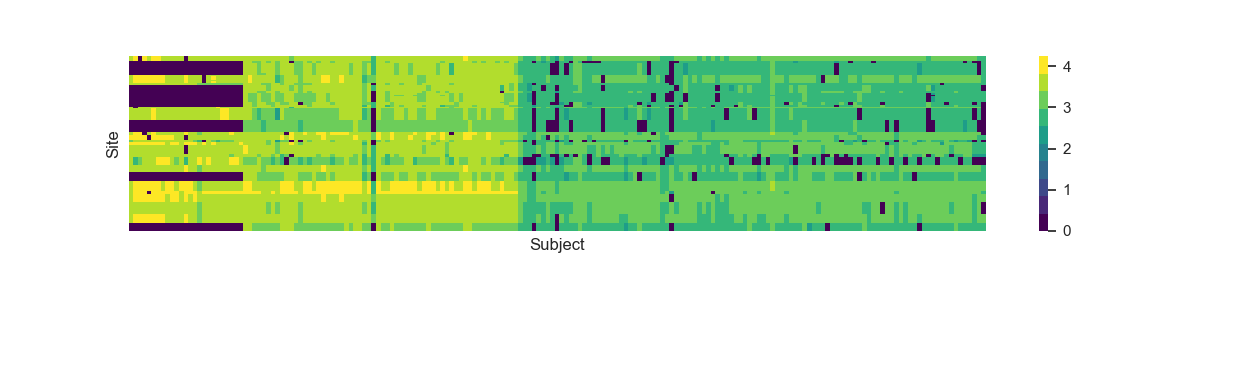

In [75]:
fig, axes = plt.subplots(1, 1, figsize=(10,3))
sns.heatmap(np.log10(igaignedu_cov.transpose()+1), cmap=c, ax=axes)
plt.tight_layout(pad=3)
axes.set_xticks([])
axes.set_xlabel('Subject')
axes.set_yticks([])
axes.set_ylabel('Site')

if not READ_ONLY:
    fig.savefig('../fig/heatmap.png', dpi=200)

<IPython.core.display.Javascript object>


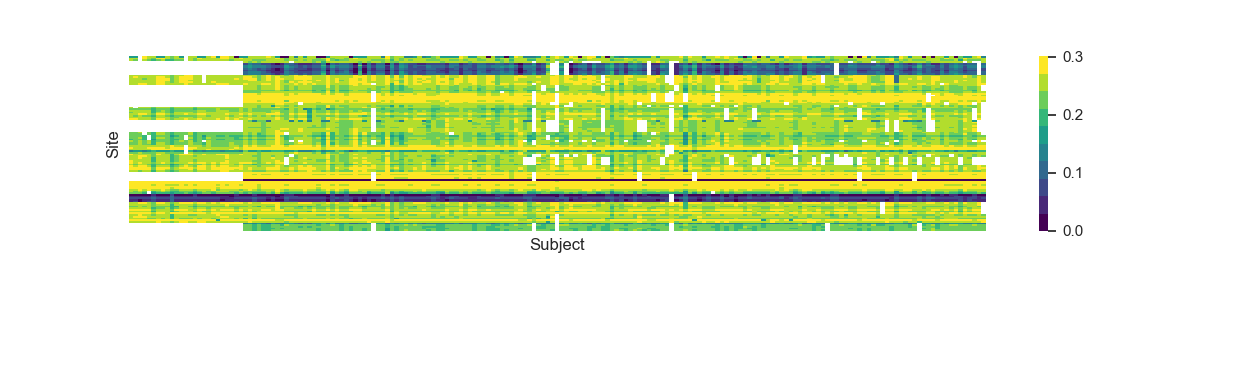

In [76]:
fig, axes = plt.subplots(1, 1, figsize=(10,3))
sns.heatmap(np.log10(igaignedu_meth.transpose()+1), cmap=c, ax=axes)
plt.tight_layout(pad=3)
axes.set_xticks([])
axes.set_xlabel('Subject')
axes.set_yticks([])
axes.set_ylabel('Site')

if not READ_ONLY:
    fig.savefig('../fig/heatmap_meth.png', dpi=200)